<a href="https://colab.research.google.com/github/harshithgowdakc/NYC-Taxi-Data/blob/main/NYC_Taxi_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name = NYC Taxi Data**

In [ ]:
!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import math
from haversine import haversine
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nyc_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Project CPG/NYC Taxi Data.csv')

In [ ]:
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [ ]:
nyc_df.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
nyc_df.tail(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198


# **Feature details:**
**id** - a unique identifier for each trip

**vendor_id** - a code indicating the provider associated with the trip record

**pickup_datetime** - date and time when the meter was engaged

**dropoff_datetime** - date and time when the meter was disengaged

**passenger_count** - the number of passengers in the vehicle (driver entered value)

**pickup_longitude** - the longitude where the meter was engaged

**pickup_latitude** - the latitude where the meter was engaged

**dropoff_longitude** - the longitude where the meter was disengaged

**dropoff_latitude** - the latitude where the meter was disengaged

**store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.

In [ ]:
nyc_df.shape

(1458644, 11)

In [ ]:
nyc_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [ ]:
nyc_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [ ]:
nyc_df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [ ]:
nyc_df.duplicated().sum()

0

In [ ]:
nyc_df[nyc_df.duplicated()]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration


In [ ]:
nyc_df.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [ ]:
nyc_df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [ ]:
#Convert timestamp to datetime format to fetch the other details as listed below

nyc_df['pickup_datetime'] = pd.to_datetime(nyc_df['pickup_datetime'])
nyc_df['dropoff_datetime'] = pd.to_datetime(nyc_df['dropoff_datetime'])

In [ ]:
nyc_df.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [ ]:
#Calculate and assign new columns to the dataframe such as weekday,
#month and pickup_hour which will help us to gain more insights from the data.
nyc_df['weekday'] = nyc_df.pickup_datetime.dt.weekday
nyc_df['month'] = nyc_df.pickup_datetime.dt.month
nyc_df['weekday_num'] = nyc_df.pickup_datetime.dt.weekday
nyc_df['pickup_hours'] = nyc_df.pickup_datetime.dt.hour

In [ ]:
#calc_distance is a function to calculate distance between pickup and dropoff coordinates using Haversine formula.
def calc_distance(nyc_df):
    pickup = (nyc_df['pickup_latitude'], nyc_df['pickup_longitude'])
    drop = (nyc_df['dropoff_latitude'], nyc_df['dropoff_longitude'])
    return haversine (pickup, drop)

In [ ]:
#Calculate distance and assign new column to the dataframe.
nyc_df['distance'] = nyc_df.apply(lambda x: calc_distance(x), axis = 1)

In [ ]:
#Calculate Speed in km/h for further insights
nyc_df['speed'] = (nyc_df.distance/(nyc_df['trip_duration']/3600))

In [ ]:
#Check the type of each variable
nyc_df.dtypes.reset_index()

,index,0
0,id,object
1,vendor_id,int64
2,pickup_datetime,datetime64[ns]
3,dropoff_datetime,datetime64[ns]
4,passenger_count,int64
5,pickup_longitude,float64
6,pickup_latitude,float64
7,dropoff_longitude,float64
8,dropoff_latitude,float64
9,store_and_fwd_flag,object


HOURS = HOUR

In [ ]:
#Dummify all the categorical features like "store_and_fwd_flag, vendor_id, month, weekday_num, pickup_hour, passenger_count" except the label i.e. "trip_duration"

dummy = pd.get_dummies(nyc_df.store_and_fwd_flag, prefix='flag')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
nyc_df = pd.concat([nyc_df,dummy], axis = 1)

dummy = pd.get_dummies(nyc_df.vendor_id, prefix='vendor_id')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
nyc_df = pd.concat([nyc_df,dummy], axis = 1)

dummy = pd.get_dummies(nyc_df.month, prefix='month')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
nyc_df = pd.concat([nyc_df,dummy], axis = 1)

dummy = pd.get_dummies(nyc_df.weekday_num, prefix='weekday_num')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
nyc_df = pd.concat([nyc_df,dummy], axis = 1)

dummy = pd.get_dummies(nyc_df.pickup_hours, prefix='pickup_hours')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
nyc_df = pd.concat([nyc_df,dummy], axis = 1)

dummy = pd.get_dummies(nyc_df.passenger_count, prefix='passenger_count')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
nyc_df = pd.concat([nyc_df,dummy], axis = 1)

In [ ]:
nyc_df.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hours_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,1,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
nyc_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'weekday', 'month', 'weekday_num', 'pickup_hours',
       'distance', 'speed', 'flag_Y', 'vendor_id_2', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'weekday_num_1', 'weekday_num_2',
       'weekday_num_3', 'weekday_num_4', 'weekday_num_5', 'weekday_num_6',
       'pickup_hours_1', 'pickup_hours_2', 'pickup_hours_3', 'pickup_hours_4',
       'pickup_hours_5', 'pickup_hours_6', 'pickup_hours_7', 'pickup_hours_8',
       'pickup_hours_9', 'pickup_hours_10', 'pickup_hours_11',
       'pickup_hours_12', 'pickup_hours_13', 'pickup_hours_14',
       'pickup_hours_15', 'pickup_hours_16', 'pickup_hours_17',
       'pickup_hours_18', 'pickup_hours_19', 'pickup_hours_20',
       'pickup_hours_21', 'pickup_hours_22', 'pickup_hours_23',
       'passenger_count_

In [ ]:
# set the option to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
nyc_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,weekday,month,weekday_num,pickup_hours,distance,speed,flag_Y,vendor_id_2,month_2,month_3,month_4,month_5,month_6,weekday_num_1,weekday_num_2,weekday_num_3,weekday_num_4,weekday_num_5,weekday_num_6,pickup_hours_1,pickup_hours_2,pickup_hours_3,pickup_hours_4,pickup_hours_5,pickup_hours_6,pickup_hours_7,pickup_hours_8,pickup_hours_9,pickup_hours_10,pickup_hours_11,pickup_hours_12,pickup_hours_13,pickup_hours_14,pickup_hours_15,pickup_hours_16,pickup_hours_17,pickup_hours_18,pickup_hours_19,pickup_hours_20,pickup_hours_21,pickup_hours_22,pickup_hours_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,3,0,17,1.498523,11.856445,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,6,6,0,1.805510,9.803672,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,1,1,11,6.385107,10.822216,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,4,2,19,1.485500,12.465738,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,3,5,13,1.188590,9.836608,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


**Univariate Analysis**

Univariate analysis is the analysis of one variable. It's major purpose is to describe patterns in the data consisting of single variable.

In [ ]:
nyc_df.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

<AxesSubplot:xlabel='passenger_count'>

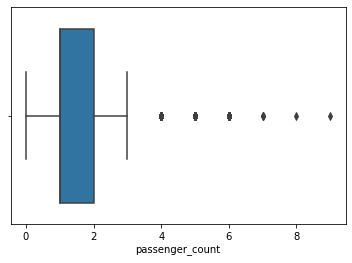

In [ ]:
sns.boxplot(nyc_df.passenger_count)

Observations:

*   There are some trips with 0 passenger count.
*   Few trips consisted of even 7, 8 or 9 passengers. Clear outliers and pointers to data inconsistency

*   Most of trip consist of passenger either 1 or 2.

Idea:
Passenger count is a driver entered value. Since the trip is not possible without passengers. It is evident that the driver forgot to enter the value for the trips with 0 passenger count. Lets analyze the passenger count distribution further to make it consistent for further analysis

In [ ]:
nyc_df.passenger_count.describe()

count    1.458644e+06
mean     1.664530e+00
std      1.314242e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

As per above details. Mean median and mode are all approx equal to 1. So we would replace the 0 passenger count with 1.

In [ ]:
nyc_df['passenger_count'] = nyc_df.passenger_count.map(lambda x: 1 if x == 0 else x)

Also, we will remove the records with passenger count > 7, 8 or 9 as they are extreme values and looks very odd to be ocupied in a taxi.

In [ ]:
nyc_df = nyc_df[nyc_df.passenger_count <= 6]

In [ ]:
nyc_df.passenger_count.value_counts()

1    1033600
2     210318
5      78088
3      59896
6      48333
4      28404
Name: passenger_count, dtype: int64

<AxesSubplot:xlabel='passenger_count', ylabel='count'>

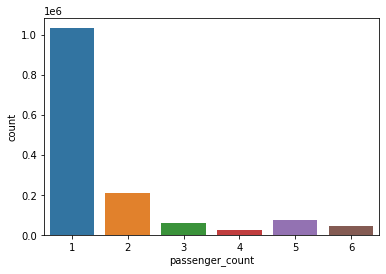

In [ ]:
sns.countplot(x = 'passenger_count', data = nyc_df)

It is evident that most of the trips was taken by single passenger and that is inline with our day to day observations

## **Vendor**

Here we analyze taxi data only for the 2 vendors which are listed as 1 and 2 in the datset.

In [ ]:
nyc_df.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,weekday,month,weekday_num,pickup_hours,distance,speed,flag_Y,vendor_id_2,month_2,month_3,month_4,month_5,month_6,weekday_num_1,weekday_num_2,weekday_num_3,weekday_num_4,weekday_num_5,weekday_num_6,pickup_hours_1,pickup_hours_2,pickup_hours_3,pickup_hours_4,pickup_hours_5,pickup_hours_6,pickup_hours_7,pickup_hours_8,pickup_hours_9,pickup_hours_10,pickup_hours_11,pickup_hours_12,pickup_hours_13,pickup_hours_14,pickup_hours_15,pickup_hours_16,pickup_hours_17,pickup_hours_18,pickup_hours_19,pickup_hours_20,pickup_hours_21,pickup_hours_22,pickup_hours_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,3,0,17,1.498523,11.856445,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,6,6,0,1.805510,9.803672,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='vendor_id', ylabel='count'>

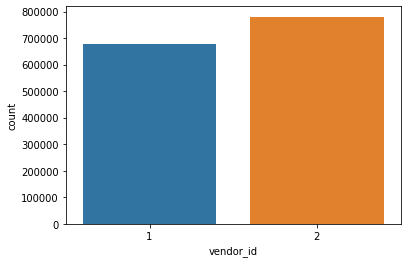

In [ ]:
sns.countplot(x = 'vendor_id', data = nyc_df)

Though both the vendors seems to have almost equal market share. But Vendor 2 is evidently more famous among the population as per the above graph.

## **Distance**

Let's now have a look on the distribution of the distance across the different types of rides.

In [ ]:
nyc_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'weekday', 'month', 'weekday_num', 'pickup_hours',
       'distance', 'speed', 'flag_Y', 'vendor_id_2', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'weekday_num_1', 'weekday_num_2',
       'weekday_num_3', 'weekday_num_4', 'weekday_num_5', 'weekday_num_6',
       'pickup_hours_1', 'pickup_hours_2', 'pickup_hours_3', 'pickup_hours_4',
       'pickup_hours_5', 'pickup_hours_6', 'pickup_hours_7', 'pickup_hours_8',
       'pickup_hours_9', 'pickup_hours_10', 'pickup_hours_11',
       'pickup_hours_12', 'pickup_hours_13', 'pickup_hours_14',
       'pickup_hours_15', 'pickup_hours_16', 'pickup_hours_17',
       'pickup_hours_18', 'pickup_hours_19', 'pickup_hours_20',
       'pickup_hours_21', 'pickup_hours_22', 'pickup_hours_23',
       'passenger_count_

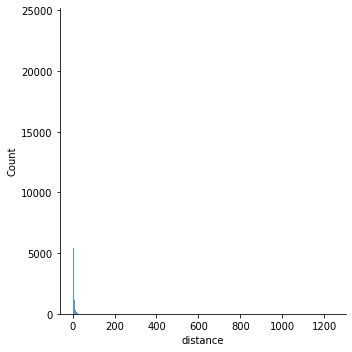

In [ ]:
sns.displot(nyc_df.distance)

In [ ]:
nyc_df.distance.describe()

count    1.458639e+06
mean     3.440876e+00
std      4.296547e+00
min      0.000000e+00
25%      1.231841e+00
50%      2.093727e+00
75%      3.875344e+00
max      1.240910e+03
Name: distance, dtype: float64

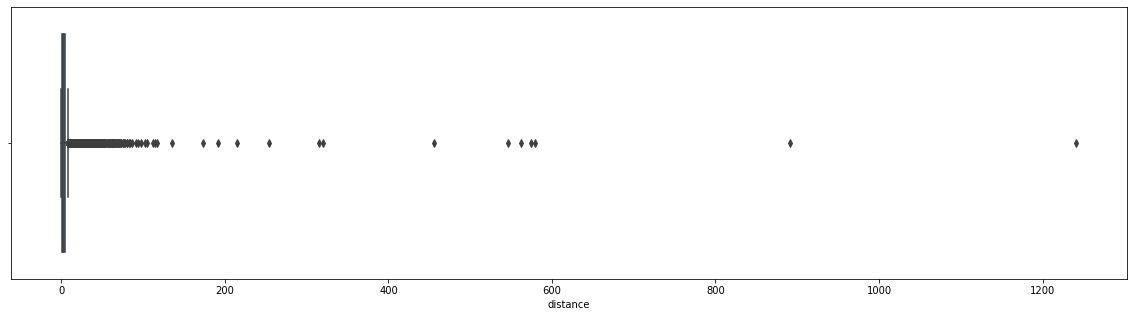

In [ ]:
plt.figure(figsize = (20,5))
sns.boxplot(nyc_df.distance)
plt.show()

Interesting find:
*   There some trips with over 100 km distance.
*   Some of the trips distance value is 0 km.

Observations:
*   mean distance travelled is approx 3.5 kms.
*   standard deviation of 4.3 which shows that most of the trips are limited to the range of 1-10 kms.

In [ ]:
zero_distance_trips = (nyc_df.distance == 0).sum()
print("There are", zero_distance_trips, "trip records with 0 km distance")

There are 5895 trip records with 0 km distance


In [ ]:
print("There are {} trip records with 0 km distance".format(nyc_df.distance[nyc_df.distance == 0 ].count()))

There are 5895 trip records with 0 km distance


In [ ]:
zero_distance_trips = nyc_df[nyc_df.distance == 0].shape[0]
print(f"There are {zero_distance_trips} trip records with 0 km distance")

There are 5895 trip records with 0 km distance


In [ ]:
nyc_df[nyc_df.distance == 0 ].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,weekday,month,weekday_num,pickup_hours,distance,speed,flag_Y,vendor_id_2,month_2,month_3,month_4,month_5,month_6,weekday_num_1,weekday_num_2,weekday_num_3,weekday_num_4,weekday_num_5,weekday_num_6,pickup_hours_1,pickup_hours_2,pickup_hours_3,pickup_hours_4,pickup_hours_5,pickup_hours_6,pickup_hours_7,pickup_hours_8,pickup_hours_9,pickup_hours_10,pickup_hours_11,pickup_hours_12,pickup_hours_13,pickup_hours_14,pickup_hours_15,pickup_hours_16,pickup_hours_17,pickup_hours_18,pickup_hours_19,pickup_hours_20,pickup_hours_21,pickup_hours_22,pickup_hours_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
246,id3487442,2,2016-02-29 18:39:12,2016-02-29 18:42:59,1,-73.981819,40.768963,-73.981819,40.768963,N,227,0,2,0,18,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
291,id0924324,2,2016-05-10 18:07:52,2016-05-10 18:26:21,2,-73.959068,40.775661,-73.959068,40.775661,N,1109,1,5,1,18,0.0,0.0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
407,id1145809,2,2016-05-16 23:15:13,2016-05-16 23:31:00,6,-73.808487,40.687336,-73.808487,40.687336,N,947,0,5,0,23,0.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
702,id3499387,1,2016-01-25 19:45:12,2016-01-25 19:54:52,1,-73.786720,40.647041,-73.786720,40.647041,N,580,0,1,0,19,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
1620,id0753277,1,2016-01-27 22:29:31,2016-01-27 22:29:58,1,-74.209854,40.816853,-74.209854,40.816853,N,27,2,1,2,22,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0


**Observations**

*   Around 6K trip record with distance equal to 0. Below are some possible explanation for such records.
  1.   Customer changed mind and cancelled the journey just after accepting it.
  2.  Software didn't recorded dropoff location properly due to which dropoff location is the same as the pickup location. 
  3.   Issue with GPS tracker while the journey is being finished.
  4.   Driver cancelled the trip just after accepting it due to some reason. So the trip couldn't start
  5.   Or some other issue with the software itself which a technical guy can explain

There is some serious inconsistencies in the data where drop off location is same as the pickup location. We can't think off imputing the distance values considering a correlation with the duration because the dropoff_location coordinates would not be inline with the distance otherwise. We will look more to it in bivariate analysis with the Trip duration.

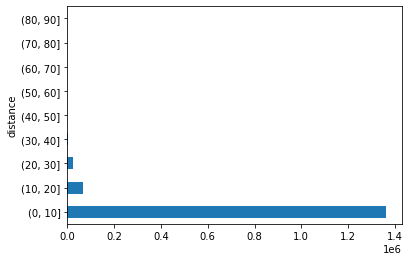

In [ ]:
nyc_df.distance.groupby(pd.cut(nyc_df.distance, np.arange(0,100,10))).count().plot(kind='barh')
plt.show()

From the above observation it is evident that most of the rides are completed between 1-10 Kms with some of the rides with distances between 10-30 kms. Other slabs bar are not visible because the number of trips are very less as compared to these slabs

In [ ]:
df = pd.DataFrame({'age': [20, 25, 30, 35, 40, 45, 50, 55, 60]})
bins = [0, 30, 50, 100]
labels = ['young', 'middle-aged', 'old']
df['age_group'] = pd.cut(df.age, bins=bins, labels=labels)

In [ ]:
df['age_group']

0          young
1          young
2          young
3    middle-aged
4    middle-aged
5    middle-aged
6    middle-aged
7            old
8            old
Name: age_group, dtype: category
Categories (3, object): ['young' < 'middle-aged' < 'old']

## **Trip duration**

In [ ]:
nyc_df.trip_duration.describe().round()

count    1458639.0
mean         959.0
std         5237.0
min            1.0
25%          397.0
50%          662.0
75%         1075.0
max      3526282.0
Name: trip_duration, dtype: float64

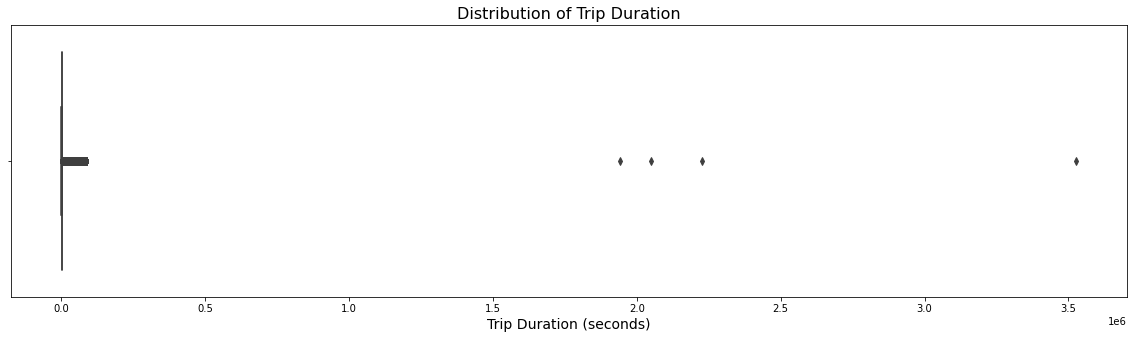

In [ ]:
plt.figure(figsize=(20, 5))
sns.boxplot(x=nyc_df.trip_duration)
plt.xlabel('Trip Duration (seconds)', fontsize=14)
plt.title('Distribution of Trip Duration', fontsize=16)
plt.show()

Interesting find:
*   Some trip durations are over 100000 seconds which are clear outliers and should be removed.

Observations:
*   There are some durations with as low as 1 second. which points towards trips with 0 km distance.
*   Major trip durations took between 10-20 mins to complete.
*   Mean and mode are not same which shows that trip duration distribution is skewed towards right.

Let's analyze more

In [ ]:
nyc_df.trip_duration.groupby(pd.cut(nyc_df.trip_duration, np.arange(1,max(nyc_df.trip_duration),3600))).count()

trip_duration
(1, 3601]             1446308
(3601, 7201]            10045
(7201, 10801]             141
(10801, 14401]             35
(14401, 18001]              5
(18001, 21601]             11
(21601, 25201]             11
(25201, 28801]             13
(28801, 32401]             17
(32401, 36001]              8
(36001, 39601]             13
(39601, 43201]              6
(43201, 46801]              8
(46801, 50401]              5
(50401, 54001]              7
(54001, 57601]              5
(57601, 61201]             10
(61201, 64801]             10
(64801, 68401]             10
(68401, 72001]              5
(72001, 75601]             10
(75601, 79201]             17
(79201, 82801]             63
(82801, 86401]           1839
(86401, 90001]              0
(90001, 93601]              0
(93601, 97201]              0
(97201, 100801]             0
(100801, 104401]            0
(104401, 108001]            0
(108001, 111601]            0
(111601, 115201]            0
(115201, 118801]          

Observations:
*   There are some trips with more than 24 hours of travel duration i.e. 86400 seconds. Which might have occured on weekends for the outstation travels.
*   Major chunk of trips are completed within an interval of 1 hour with some good numbers of trips duration going above 1 hour.

Let's look at those trips with huge duration, these are outliers and should be removed for the data consistency.

In [ ]:
nyc_df[nyc_df.trip_duration > 86400]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,weekday,month,weekday_num,pickup_hours,distance,speed,flag_Y,vendor_id_2,month_2,month_3,month_4,month_5,month_6,weekday_num_1,weekday_num_2,weekday_num_3,weekday_num_4,weekday_num_5,weekday_num_6,pickup_hours_1,pickup_hours_2,pickup_hours_3,pickup_hours_4,pickup_hours_5,pickup_hours_6,pickup_hours_7,pickup_hours_8,pickup_hours_9,pickup_hours_10,pickup_hours_11,pickup_hours_12,pickup_hours_13,pickup_hours_14,pickup_hours_15,pickup_hours_16,pickup_hours_17,pickup_hours_18,pickup_hours_19,pickup_hours_20,pickup_hours_21,pickup_hours_22,pickup_hours_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736,1,1,1,0,20.148692,0.037394,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578,5,2,5,22,5.982495,0.010508,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612,1,1,1,6,1.635130,0.002643,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282,5,2,5,22,19.900689,0.020317,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0


**Observations:**
*   These trips ran for more than 20 days, which seems unlikely by the distance travelled.
*   All the trips are taken by vendor 1 which points us to the fact that this vendor might allows much longer trip for outstations.
*   All these trips are either taken on Tuesday's in 1st month or Saturday's in 2nd month. There might be some relation with the weekday, pickup location, month and the passenger.
*   But they fail our purpose of correct prediction and bring inconsistencies in the algorithm calculation.

We should get rid of them for the sake of data consistency. Those are black swans !!

In [ ]:
nyc_df = nyc_df[nyc_df.trip_duration <= 86400]

Let's visualize the number of trips taken in slabs of 0-10, 20-30 ... minutes respectively

<AxesSubplot:ylabel='trip_duration'>

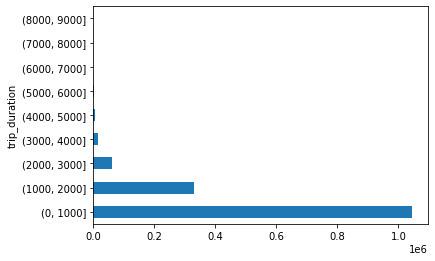

In [ ]:
nyc_df.trip_duration.groupby(pd.cut(nyc_df.trip_duration, np.arange(0,10000,1000))).count().plot(kind='barh')

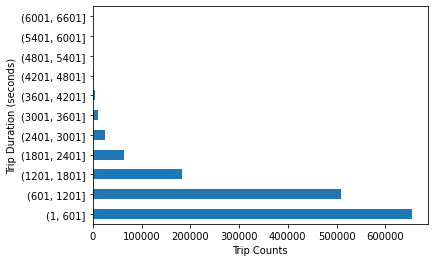

In [ ]:
nyc_df.trip_duration.groupby(pd.cut(nyc_df.trip_duration, np.arange(1,7200,600))).count().plot(kind='barh')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

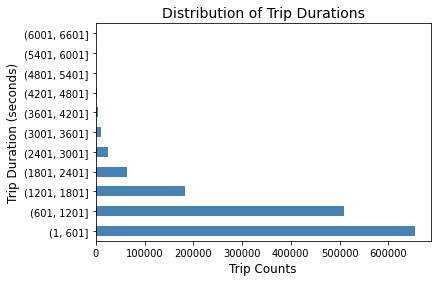

In [ ]:
bins = pd.cut(nyc_df.trip_duration, np.arange(1,7200,600))

# Count the number of trips in each bin and create a horizontal bar chart
trip_counts = nyc_df.trip_duration.groupby(bins).count()
ax = trip_counts.plot(kind='barh', color='steelblue')

# Set the x-axis and y-axis labels
ax.set_xlabel('Trip Counts', fontsize=12)
ax.set_ylabel('Trip Duration (seconds)', fontsize=12)

# Set the title of the chart
ax.set_title('Distribution of Trip Durations', fontsize=14)

# Show the chart
plt.show()

We can observe that most of the trips took 0 - 30 mins to complete i.e. approx 1800 secs. Let's move ahead to next feature.

**Speed**

Speed is a function of distance and time. Let's visualize speed in different trips.
Maximum speed limit in NYC is as follows:
*   25 mph in urban area i.e. 40 km/h
*   65 mph on controlled state highways i.e. approx 104 km/h

In [ ]:
nyc_df.speed.describe().round()

count    1458635.0
mean          14.0
std           15.0
min            0.0
25%            9.0
50%           13.0
75%           18.0
max         9275.0
Name: speed, dtype: float64

<AxesSubplot:xlabel='speed'>

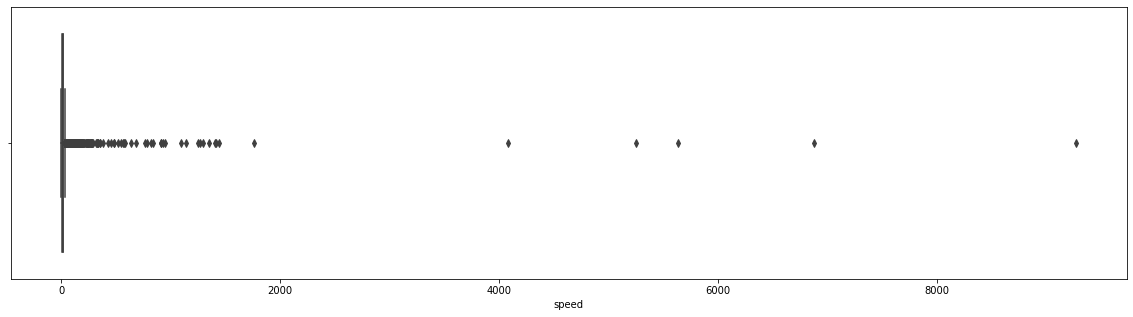

In [ ]:
plt.figure(figsize = (20,5))
sns.boxplot(nyc_df.speed)

**Interesting find:**

*   Many trips were done at a speed of over 200 km/h. Going SuperSonic..!!

Let's remove them and focus on the trips which were done at less than 104 km/h as per the speed limits

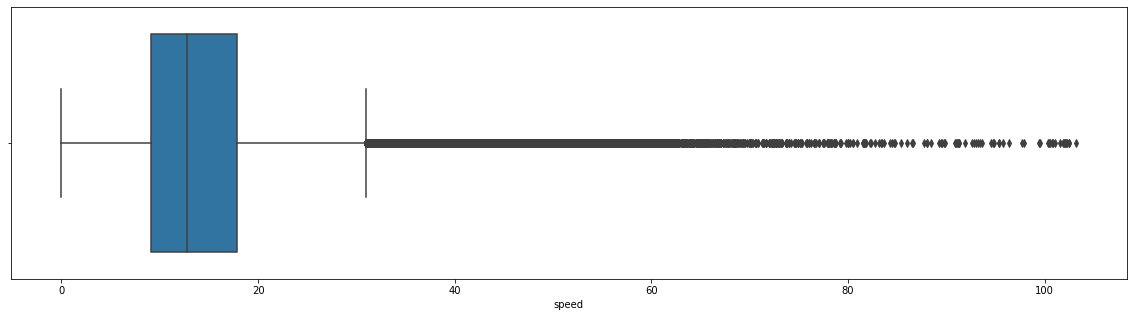

In [ ]:
nyc_df = nyc_df[nyc_df.speed <= 104]
plt.figure(figsize = (20,5))
sns.boxplot(nyc_df.speed)
plt.show()

**Observations:**
*   Trips over 30 km/h are being considered as outliers but we cannot ignore them because they are well under the highest speed limit of 104 km/h on state controlled highways.
*   Mostly trips are done at a speed range of 10-20 km/h with an average speed of around 14 km/h.

Let's take a look at the speed range ditribution with the help of graph.

<AxesSubplot:ylabel='speed'>

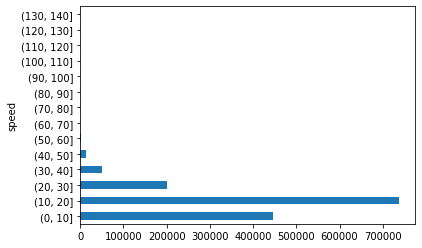

In [ ]:
nyc_df.speed.groupby(pd.cut(nyc_df.speed, np.arange(0,150,10))).count().plot(kind = 'barh')

It is evident from this graph what we thought off earlier i.e. most of the trips were done at a speed range of 10-20 km/H.

**Store_and_fwd_flag**

This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward

In [ ]:
nyc_df.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,weekday,month,weekday_num,pickup_hours,distance,speed,flag_Y,vendor_id_2,month_2,month_3,month_4,month_5,month_6,weekday_num_1,weekday_num_2,weekday_num_3,weekday_num_4,weekday_num_5,weekday_num_6,pickup_hours_1,pickup_hours_2,pickup_hours_3,pickup_hours_4,pickup_hours_5,pickup_hours_6,pickup_hours_7,pickup_hours_8,pickup_hours_9,pickup_hours_10,pickup_hours_11,pickup_hours_12,pickup_hours_13,pickup_hours_14,pickup_hours_15,pickup_hours_16,pickup_hours_17,pickup_hours_18,pickup_hours_19,pickup_hours_20,pickup_hours_21,pickup_hours_22,pickup_hours_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,3,0,17,1.498523,11.856445,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,6,6,0,1.805510,9.803672,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
nyc_df['store_and_fwd_flag'].value_counts()

N    1450433
Y       8044
Name: store_and_fwd_flag, dtype: int64

<AxesSubplot:xlabel='store_and_fwd_flag', ylabel='count'>

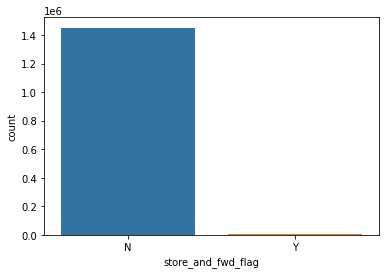

In [ ]:
sns.countplot(nyc_df.store_and_fwd_flag)

In [ ]:
nyc_df.flag_Y.value_counts(normalize=True)

0    0.994485
1    0.005515
Name: flag_Y, dtype: float64

**Observations:**
*   Above result shows that only about 1% of the trip details were stored in the vehicle first before sending it to the server. This might have occured because of the following reasons:

  1.   Outstation trips didn't had proper connection at the time when trip completes.

  2.   Temporary loss of signals while the trip was about to finish
  3.   Inconsistent signal reception over the trip duration.
  4.   The GPS or mobile device battery was down when the trip finished.


Let's check further

In [ ]:
nyc_df.flag_Y.value_counts()

0    1450433
1       8044
Name: flag_Y, dtype: int64

Above result shows that around 8K trips had to store the flag and then report to the server when the connection was established. Let's check the respective distribution with the vendors for the offline trips.

In [ ]:
nyc_df.vendor_id[nyc_df.flag_Y == 1].value_counts()

1    8044
Name: vendor_id, dtype: int64

Observations:
*   Above result shows that all the offline trips were taken by vendor 1. We already know that vendor 2 has greater market share as compared to vendor 1. So, there can be two reasons for this scenario.



  1.   Either vendor 1 utilizes advance technology then vendor 2 to store and forward trip details in case of temporary signal loss.
  2.   Or vendor 1 uses poor infrastructure which often suffers from the server connection instability due to which they have to store the trip info in the vehicle and send it to the server later when the server connection is back.

Let's check if there is some relation to the other metrics for these trips?

In [67]:
nyc_df[nyc_df.flag_Y == 1].head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,weekday,month,weekday_num,pickup_hours,distance,speed,flag_Y,vendor_id_2,month_2,month_3,month_4,month_5,month_6,weekday_num_1,weekday_num_2,weekday_num_3,weekday_num_4,weekday_num_5,weekday_num_6,pickup_hours_1,pickup_hours_2,pickup_hours_3,pickup_hours_4,pickup_hours_5,pickup_hours_6,pickup_hours_7,pickup_hours_8,pickup_hours_9,pickup_hours_10,pickup_hours_11,pickup_hours_12,pickup_hours_13,pickup_hours_14,pickup_hours_15,pickup_hours_16,pickup_hours_17,pickup_hours_18,pickup_hours_19,pickup_hours_20,pickup_hours_21,pickup_hours_22,pickup_hours_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
348,id1633648,1,2016-06-20 14:19:16,2016-06-20 14:34:34,1,-73.977905,40.754871,-73.952774,40.768166,Y,918,0,6,0,14,2.581730,10.124431,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
491,id2042535,1,2016-02-12 12:36:38,2016-02-12 12:47:07,1,-73.978981,40.756519,-73.992165,40.749203,Y,629,4,2,4,12,1.376632,7.878975,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


**Observations:**

*   Some trips are local some cover longer distance

*   Almost each day is listed against offline trips.

*   Offline trips were taken almost at all hours as per the search result.

*   There is no month which appears to be more dominant in the results.

*   Even the trip duration covers different scales.

So all in all there doesn't seems to be any relation with either of the metric for the offline trips. Let's move ahead

### **Total trips Per Hour**

Let's take a look at the distribution of the pickups across the 24 hour time scale.

Hours = hour

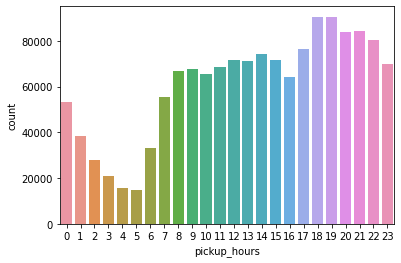

In [70]:
sns.countplot(nyc_df.pickup_hours)
plt.show()

**Observation:**

*   It's inline with the general trend of taxi pickups which starts increasing from 6AM in the morning and then declines from late evening i.e. around 8 PM. There is no unusual behavior here.

### **Total trips per weekday**

Let's take a look now at the distribution of taxi pickups across the week.

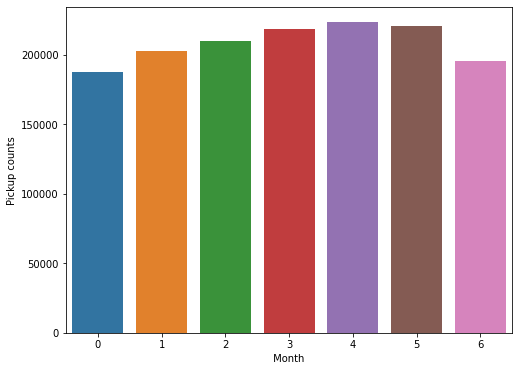

In [72]:
plt.figure(figsize = (8,6))
sns.countplot(nyc_df.weekday_num)
plt.xlabel(' Month ')
plt.ylabel('Pickup counts')
plt.show()

**Observation:**
*   Here we can see an increasing trend of taxi pickups starting from Monday till Friday. The trend starts declining from saturday till monday which is normal where some office going people likes to stay at home for rest on the weekends.

Let's drill down more to see the hourwise pickup pattern across the week

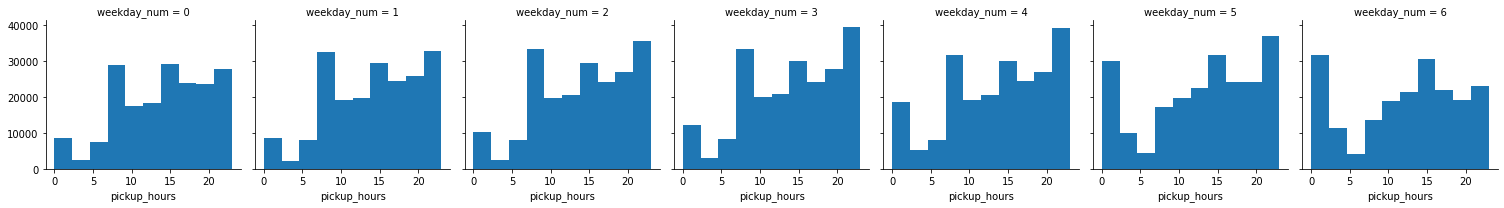

In [75]:
n = sns.FacetGrid(nyc_df, col='weekday_num')
n.map(plt.hist, 'pickup_hours')
plt.show()

**Interesting find:**
*   Taxi pickups increased in the late night hours over the weekend possibly due to more outstation rides or for the late night leisures nearby activities.
*   Early morning pickups i.e before 5 AM have increased over the weekend in comparison to the office hours pickups i.e. after 7 AM which have decreased due to obvious reasons.
*   Taxi pickups seems to be consistent across the week at 15 Hours i.e. at 3 PM.

### **Total trips per month**

Let's take a look at the trip distribution across the months to understand if there is any diffrence in the taxi pickups in different months

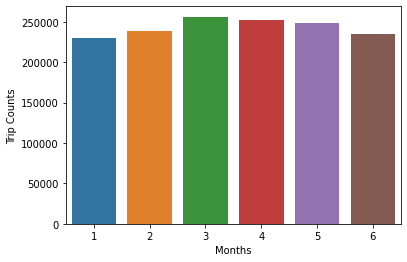

In [77]:
sns.countplot(nyc_df.month)
plt.ylabel('Trip Counts')
plt.xlabel('Months')
plt.show()

Quite a balance across the months here. It could have been more equivalent if we wouldn't have removed the inconsistent records in our study of the univariate analysis

## **Bivariate Analysis**

Bivariate analysis is used to find out if there is a relationship between two sets of values. It usually involves the variables X and Y.

### **Trip Duration per hour**

We need to aggregate the total trip duration to plot it agaist the month. The aggregation measure can be anything like sum, mean, median or mode for the duration. Since we already did the outlier analysis, so we can take the mean to visualize the pattern which should not result in the bias of the general trend.

*   Lets take a look.

TypeError: ignored

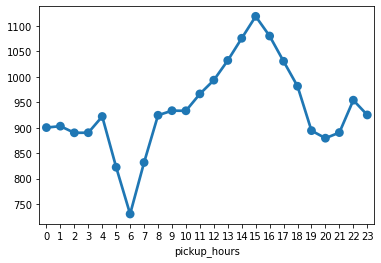

In [109]:
group1 = nyc_df.groupby('pickup_hours').trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('pickup_hours')
plt.show()

**Observations:**
*   Average trip duration is lowest at 6 AM when there is minimal traffic on the roads.
*   Average trip duration is generally highest around 3 PM during the busy streets.
*   Trip duration on an average is similar during early morning hours i.e. before 6 AM & late evening hours i.e. after 6 PM.

### **Trip duration per weekday**

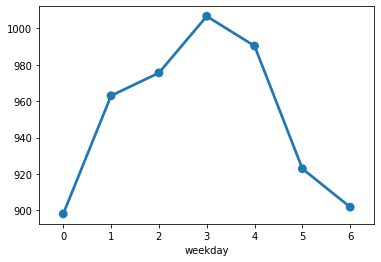

In [108]:
group2 = nyc_df.groupby('weekday').trip_duration.mean()
sns.pointplot(group2.index, group2.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('weekday')
plt.show()

We can see that trip duration is almost equally distributed across the week on a scale of 0-1000 minutes with minimal difference in the duration times. Also, it is observed that trip duration on thursday is longest among all days.

### **Trip duration per month**

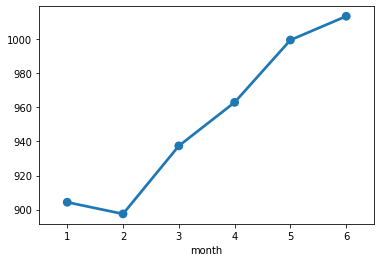

In [107]:
group3 = nyc_df.groupby('month').trip_duration.mean()
sns.pointplot(group3.index, group3.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('month')
plt.show()

Observations:
*   We can see an increasing trend in the average trip duration along with each subsequent month.
*   The duration difference between each month is not much. It has increased gradually over a period of 6 months.
*   It is lowest during february when winters starts declining.
*   There might be some seasonal parameters like wind/rain which can be a factor of this gradual increase in trip duration over a period. Like May is generally the considered as the wettest month in NYC and which is inline with our visualization. As it generally takes longer on the roads due to traffic jams during rainy season. So natually the trip duration would increase towards April May and June.

In [68]:
nyc_df.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,weekday,month,weekday_num,pickup_hours,distance,speed,flag_Y,vendor_id_2,month_2,month_3,month_4,month_5,month_6,weekday_num_1,weekday_num_2,weekday_num_3,weekday_num_4,weekday_num_5,weekday_num_6,pickup_hours_1,pickup_hours_2,pickup_hours_3,pickup_hours_4,pickup_hours_5,pickup_hours_6,pickup_hours_7,pickup_hours_8,pickup_hours_9,pickup_hours_10,pickup_hours_11,pickup_hours_12,pickup_hours_13,pickup_hours_14,pickup_hours_15,pickup_hours_16,pickup_hours_17,pickup_hours_18,pickup_hours_19,pickup_hours_20,pickup_hours_21,pickup_hours_22,pickup_hours_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,3,0,17,1.498523,11.856445,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,6,6,0,1.805510,9.803672,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### **Trip duration per vendor**

TypeError: ignored

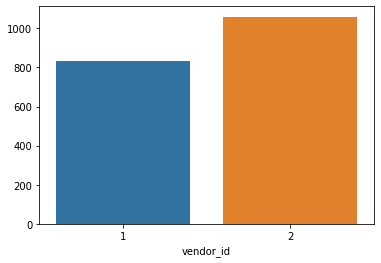

In [113]:
group4 = nyc_df.groupby('vendor_id').trip_duration.mean()
sns.barplot(group4.index, group4.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Vendor')
plt.show()

Vendor 2 takes the crown. Average trip duration for vendor 2 is higher than vendor 1 by approx 200 seconds i.e. atleast 3 minutes per trip.

### **Trip duration v/s Flag**

Let's visualize if there is any effect of flag setting on the trip duration?

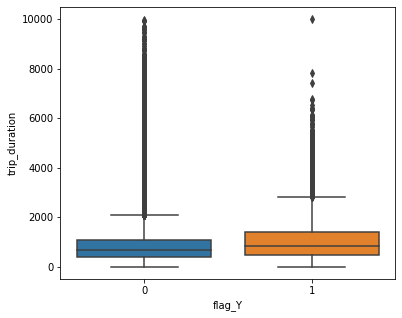

In [115]:
plt.figure(figsize = (6,5))
plot_dur = nyc_df.loc[(nyc_df.trip_duration < 10000)]
sns.boxplot(x = "flag_Y", y = "trip_duration", data = plot_dur)
plt.show()

Observations:

*   Trip durations scale is less for the trips where the flag is set i.e. the trip details are stored before sending it to the server.
*   Trip duration outliers are also less for the trips with flag 'Y' as compared the trips with flag 'N'.
*   Trip duration is longer for the trips where the flag is not set.
*   Inter quartile range of trip duration is more for the trips with the flag 'Y' as compared to the trips with flag 'N' but the median value is almost equal for both.